# VQE to find Ground State Energy of Nitrogen

In this notebook, I have used Variational Quantum Eigensolver to find ground state energy of Hamiltonian

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver, MinimumEigensolverResult
from qiskit.primitives import Estimator

from qiskit_nature import settings
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

settings.tensor_unwrapping = False
settings.use_pauli_sum_op = False

### Step 1- 
Creating nitrogen molecule and building the electronic Hamiltonian

In [6]:
# Create molecule
driver = PySCFDriver(atom='N 0.0 0.0 0.0; N 0.0 0.0 1.1', basis='6-31g*')

# Get second quantized Hamiltonian
problem = driver.run()
qubit_mapper = ParityMapper(num_particles=problem.num_particles)
print(problem.num_particles, problem.num_spatial_orbitals)

(7, 7) 28


### Step 2-
As can be seen, this is a large molecult and it is very difficult to map it to a quantum computer, so first we have to resuce this molecule. Reduce the problem size by using Qiskit Active Space Transformer which uses some techniques to select orbitals that we want for our problem.

In [7]:
# Activate space transformer
active_space_transformer = ActiveSpaceTransformer(4, 4)
as_problem = active_space_transformer.transform(problem)
print(as_problem.num_particles, as_problem.num_spatial_orbitals)

(2, 2) 4


In [8]:
as_hamiltonian = qubit_mapper.map(as_problem.hamiltonian.second_q_op())
print(as_hamiltonian.num_qubits)

6


### Step 3-
Here, we have used the defined molecule reduced after transformation to solve the problem.

In [9]:
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(as_hamiltonian)
exact_result = as_problem.interpret(exact_result)

In [10]:
print(exact_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -132.281418022238
  - computed part:      -5.425594688511
  - ActiveSpaceTransformer extracted energy part: -126.855823333727
~ Nuclear repulsion energy (Hartree): 23.572439395527
> Total ground state energy (Hartree): -108.708978626711
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  14.55089116]
 


### Step 4-

Next step is using VQE to solve the problem. First, initializing the VQE ansatz.

In [11]:
# Setup ansatz
initial_state = HartreeFock(
    num_spatial_orbitals=as_problem.num_spatial_orbitals, 
    num_particles=as_problem.num_particles, 
    qubit_mapper=qubit_mapper)

ansatz = UCCSD(
    num_spatial_orbitals=as_problem.num_spatial_orbitals, 
    num_particles=as_problem.num_particles, 
    qubit_mapper=qubit_mapper, 
    initial_state=initial_state)

### Step 5-
Setting up the VQE Solver by using COBYLA optimizer.

In [17]:
# Setup optimizer
optimizer = COBYLA(maxiter=2000)

energies = []
def callback(nfev, x, fx, *args):
    energies.append(fx)

# Setup VQE
estimator = Estimator()
vqe_solver = VQE(estimator, ansatz, optimizer, callback=callback)

### Step 6-
Solving the problem by using the defined VQE solver.

In [18]:
# Solve for the groundstate
result = vqe_solver.compute_minimum_eigenvalue(as_hamiltonian)
result = as_problem.interpret(result)

In [19]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -132.28141654086
  - computed part:      -5.425593207133
  - ActiveSpaceTransformer extracted energy part: -126.855823333727
~ Nuclear repulsion energy (Hartree): 23.572439395527
> Total ground state energy (Hartree): -108.708977145333
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  14.55089116]
 


To visualize the energy evolution of VQE solver, we can map the energies against the steps run during optimization.

In [20]:
vqe_energies = []

for energy in energies:
    result = MinimumEigensolverResult()
    result.eigenvalue = energy
    vqe_energies.append(as_problem.interpret(result).total_energies[0])

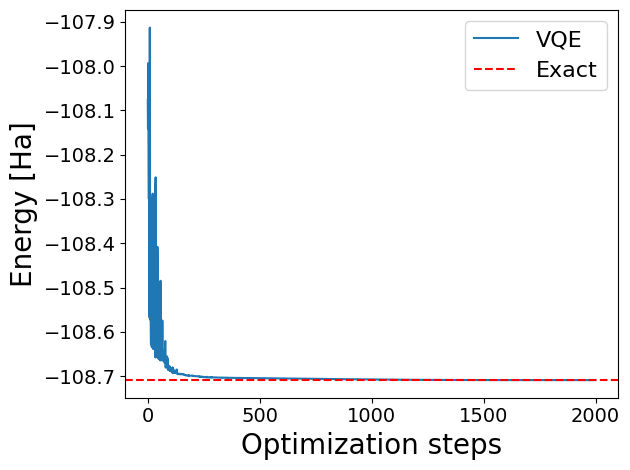

In [21]:
plt.plot(vqe_energies, label='VQE')
plt.axhline(exact_result.total_energies[0], color='red', linestyle='dashed', label='Exact')

plt.ylabel('Energy [Ha]', fontsize=20)
plt.xlabel('Optimization steps', fontsize=20)

plt.tick_params(which='both', labelsize=14)
plt.legend(fontsize=16)
plt.tight_layout()

This code is modification from a part of IBM's work on Quantum Natural Science.